# Setting Source Folder

In [2]:
import os, sys

filedir = os.path.abspath(".")

currentdir = os.path.dirname(os.path.abspath(".")) # workaround to adding local modules

parentdir = os.path.dirname(os.path.abspath(""+currentdir))
print(f'CurrentDir: {currentdir}')
print(f'ParentDir: {parentdir}')

sys.path.insert(0, currentdir)

CurrentDir: /Users/renan.cristofalo/Documents/git/multimorbity_use
ParentDir: /Users/renan.cristofalo/Documents/git


# Importing Libraries

In [3]:

import pandas as pd
import numpy as np
import os.path as osp
from pathlib import Path

from src.ml.feature_selection import loop_k_features, Lasso_selection, BorutaShap_selection, collinear_removal, voting
from src.ml.utils.preprocessors import select_preprocessor
from src.ml.utils.utils import get_ct_feature_names, write_joblib
from src.visualization.data_visualization import plot
from src.config import *


from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import set_config


import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 200
set_config(display="diagram")

# Reading Data

In [4]:
SEED = 123

DATA_PATH = osp.join('..', 'data','processed','dataset_clean.csv')

DATA_DIR = osp.join('..', 'data','feature_selection')
DATA_DIR_RAW = osp.join(DATA_DIR,'raw')



In [5]:

if not osp.exists(DATA_DIR_RAW):
    os.makedirs(DATA_DIR_RAW)
    
if not osp.exists(osp.join(DATA_DIR_RAW,'df_train.parquet')):
    pdf = pd.read_csv(DATA_PATH)
    
    X = pdf.drop(TARGET, axis = 1)
    y = pdf[TARGET]
    
    # Separating dataset onto train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
    pd.DataFrame(data=pd.concat([X_train, y_train], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    pd.DataFrame(data=pd.concat([X_test, y_test], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
else:
    # reading files
    df_train=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    df_test=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
    
    X_train, X_test, y_train, y_test  = df_train.drop(TARGET, axis = 1), df_test.drop(TARGET, axis = 1), df_train[TARGET], df_test[TARGET]
    
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2444, 381)
X_test shape: (1048, 381)


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'pronto_atendimento'}, xlabel='pronto_atendimento', ylabel='count'>)

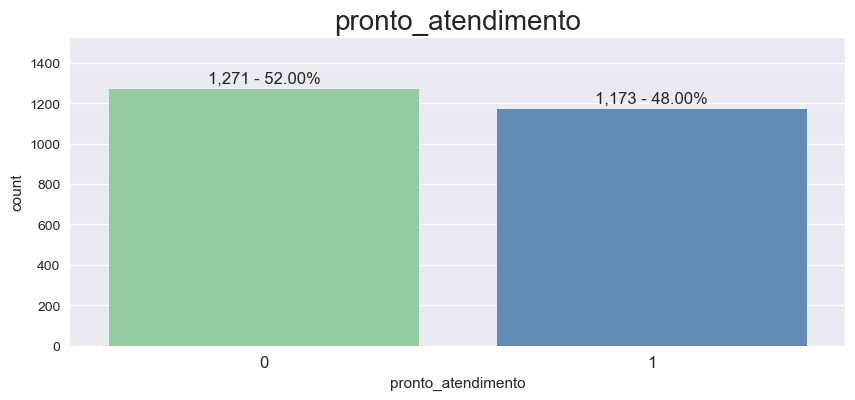

In [6]:
plot(
       'countplot'
     , df =y_train.to_frame()
     , columns= [TARGET]
     , ncols=1
     , plot_size = (10,4)
    #  , title=f"Target distribution - {'hospital_death'.title()} - ALL"
    , xlabel_rotation=0
    , rotation=0
)


# Data Preparation

In [7]:
# Defining preprocessor

preprocessor = select_preprocessor('TargetEncoding', X = X_train)
preprocessor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('float',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['altura', 'peso', 'tafumo',
                                                   'tmfumo', 'tpafumo',
                                                   'cigdia', 'CW', 'pecas',
                                                   'abban', 'camt', 'afft',
                                                   'afmt', 'dcamt', 'dbicit',
                                                   'sent', 'deit', 'tvs',
                                                   'tamenf', 'tmmenf', 'nserv',
                                                   'sat', 'tsono', 'vavc'...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['setor', 'qplan',
                                                   'imedenfout', 'postoqual',
                                                   'tservout', 'eservout',
                                                   'qcovid', 'omdt', 'outqual',
                                                   'lca', 'pessoamt',
                                                   'pessoamta', 'pessoaem',
                                                   'pessoainf', 'pessoasp']),
                                                 ('bypass',
                                                  Pipeline(steps=[('Bypass',
                                                                   <src.ml.utils.preprocessors.BypassTransformer object at 0x1281f1b20>)]),
                                                  [])])),
                ('sparse_to_dense', SparseToDenseTransformer())])

In [8]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train, y=y_train)

# Get the column names after transformation
output_features = get_ct_feature_names(preprocessor[-2])

# Transform both the training and test data using the same preprocessor
# X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(data=preprocessor.transform(X_train), columns=output_features)
# X_test_preprocessed = pd.DataFrame.sparse.from_spmatrix(data=preprocessor.transform(X_test), columns=output_features)
X_train_preprocessed = pd.DataFrame(data=preprocessor.transform(X_train), columns=output_features)
X_test_preprocessed = pd.DataFrame(data=preprocessor.transform(X_test), columns=output_features)

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

X_train.shape:  (2444, 1177)
X_test.shape:  (1048, 1177)


In [8]:
X_train_preprocessed.sample(10)

,altura,peso,tafumo,tmfumo,tpafumo,cigdia,cw,pecas,abban,camt,afft,afmt,dcamt,dbicit,sent,deit,tvs,tamenf,tmmenf,nserv,sat,tsono,vavc,vepil,vitu,vflu,vpnm,taca,tmca,pfarm,vqued,taacam,tmacam,intht,cancer,peso1,altura1,bmi,rendasetor,rensetor10,urg,rensetor5,irensetor1_2,irensetor1_3,irensetor1_4,irensetor1_5,irensetor1_6,irensetor1_7,irensetor1_8,irensetor1_9,irensetor1_10,banheiroabep,empabep,carroabep,microabep,lavaloucabep,gelaabep,freeabep,lavaroupaabep,dvdabep,microondasabep,motoabep,secaabep,chefeabep,aguaabep,pavabep,abep,esperado,total,mor2,pw,pw1,pop,idade,icovid,depre1,depre2,depre3,depre4,depre5,depre6,depre7,depre8,depre9,depress,depre_algo,depresscat,phq_sum_b,depre_cut,ansi1,ansi2,ansi3,ansi4,ansi5,ansi6,ansi7,ansiss,ansi_algo,gad_sum_b,ansi_cut,...,abepcat_b1,abepcat_b2,abepcat_c1,abepcat_c2,abepcat_de,abepcat_none,esc4j_ensino_fundamental_completo_medio_incom,esc4j_ensino_medio_completo_superior_incomple,esc4j_ensino_superior_completo_ou_mais,esc4j_nunca_ensino_fundamental_incompleto,esc4j_none,sexj_male,cor2_branca,cor2_preta_parda_amar_indig,cor2_none,abep4_a_b1,abep4_c1,abep4_c2,abep4_de,abep4_none,j_1,j_2,j_3,j_4,j_5,j_6,j_7,j_homem_branco_rico_escolar,j_mulher_preta_parda_pobre_baixa_esc,j_none,ds_fim_de_semana,id4_18_29,id4_30_59,id4_60_69,id4_70,idibge_18_29,idibge_30_39,idibge_40_49,idibge_50_59,idibge_60_69,idibge_70_79,idibge_80,estrato_fem_18_29,estrato_fem_30_39,estrato_fem_40_49,estrato_fem_50_59,estrato_fem_60_69,estrato_fem_70_79,estrato_fem_80,estrato_masc_18_29,estrato_masc_30_39,estrato_masc_40_49,estrato_masc_50_59,estrato_masc_60_69,estrato_masc_70_79,estrato_masc_80,gad_sintomas_leves,gad_sintomas_moderados,gad_sintomas_sem_sintomas,gad_sintomas_severos,gad_sintomas_none,gad_severity_mild,gad_severity_minimal,gad_severity_moderate,gad_severity_severe,gad_severity_none,gad_severo_nao,gad_severo_sim,gad_severo_none,phq_severity_mild,phq_severity_minimal,phq_severity_moderate,phq_severity_moderately_severe,phq_severity_severe,phq_severity_none,id2_idoso,pros_nao,pros_sim,pros_none,testecovid_algum_teste_laboratorial_nao_tem_certeza_de_qual,testecovid_diagnostico_medico_sem_a_realizacao_de_teste_laboratorial,testecovid_ign,testecovid_nao,testecovid_sim_teste_rt_qpcr_virus,testecovid_sim_teste_rapido_anticorpos,setor,qplan,imedenfout,postoqual,tservout,eservout,qcovid,omdt,outqual,lca,pessoamt,pessoamta,pessoaem,pessoainf,pessoasp
1474,-1.17,-1.51,0.00,-0.00,-0.00,-0.00,0.38,-0.12,0.25,2.13,0.00,-0.00,2.77,0.00,-0.96,-0.37,-0.28,-0.31,-0.27,-0.16,0.44,0.18,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.31,0.00,-0.00,-0.00,-0.22,-1.51,-1.17,-1.19,0.87,1.25,-0.65,1.45,-0.32,-0.34,-0.33,-0.37,-0.32,-0.35,-0.34,3.07,-0.31,0.89,-0.14,0.67,-0.91,-0.19,-0.12,-0.84,0.31,-0.37,0.52,-0.44,-0.42,1.82,0.08,1.00,0.60,-0.76,-0.14,-1.13,0.70,-0.41,0.33,0.40,-0.43,2.14,2.21,-0.52,1.87,-0.39,-0.32,2.62,-0.27,-0.25,1.41,-0.34,-0.34,0.76,2.05,-0.61,-0.41,1.62,-0.48,2.80,-0.48,-0.35,-0.55,-0.55,0.81,-0.46,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.36,0.52,0.48,0.47,0.48,0.48,0.47,0.48,0.48,0.48,0.51,0.51,0.46,0.43,0.50
1744,0.00,-0.09,0.00,-0.00,-0.00,-0.00,-1.51,-0.56,-0.22,-0.81,0.00,-0.00,-0.53,-0.60,-0.12,-0.53,-0.60,0.00,0.00,-0.16,-0.16,-0.08,0.00,0.00,-0.00,-0.11,-0.00,0.00,0.00,-0.31,0.00,0.00,-0.00,-0.00,-0.22,-0.09,0.00,0.00,-0.49,-0.88,-0.65,-0.72,-0.32,2.91,-0.33,-0.37,-0.32,-0.35,-0.34,-0.33,-0.31,-0.60,-0.14,-1.02,-0.91,-0.19,-0.12,-0.84,0.31,-0.37,0.52,-0.44,-0.42,1.82,0.08,-1.00,-0.42,1.92,-0.19,-1.13,-1.37,0.65,1.01,-1.00,-0.43,-0.47,2.21,-0.52,1.87,-0.39,-0.32,2.62,-0.27,-0.25,0.94,-0.34,-0.34,1.12,2.05,1.65,2.46,1.62,

# FEATURE SELECTION

## Colinear Removal

In [9]:
collinear_support, collinear_features, record_collinear = collinear_removal(X_train_preprocessed, y_train, 0.8)

X_train_preprocessed = X_train_preprocessed[collinear_features]
X_test_preprocessed = X_test_preprocessed[collinear_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

341 features with a correlation magnitude greater than 0.80.

X_train.shape:  (2444, 836)
X_test.shape:  (1048, 836)


In [10]:
record_collinear.head()

,drop_feature,corr_feature,corr_value
0,eserv_none,urg,-1.00
1,tserv_none,urg,-1.00
2,tserv_none,eserv_none,1.00
3,eserv_nao_fui_encaminhado,urg,0.85
4,eserv_nao_fui_encaminhado,eserv_none,-0.85


In [11]:
X_train_preprocessed.sample(10)

,tafumo,tmfumo,tpafumo,cigdia,cw,pecas,camt,afmt,dcamt,dbicit,sent,deit,tvs,tamenf,nserv,sat,tsono,vavc,vepil,vitu,vflu,vpnm,taca,tmca,pfarm,vqued,taacam,intht,altura1,bmi,rendasetor,rensetor10,urg,irensetor1_2,irensetor1_3,irensetor1_4,irensetor1_5,irensetor1_6,irensetor1_7,irensetor1_8,irensetor1_9,banheiroabep,gelaabep,lavaroupaabep,motoabep,chefeabep,aguaabep,abep,esperado,total,mor2,pw,pw1,depre3,depre4,depre5,depre6,depre7,depre8,depre9,depress,ansi2,ansi3,ansi4,ansi5,ansi6,ansi7,ansiss,popw,m2,hospit,inseg,multi_calc,nmor_0,nmor_1_apenas_o_proprio_respondente,nmor_10_ou_mais,nmor_2,nmor_3,nmor_4,nmor_5,nmor_6,nmor_7,nmor_8,genero_homem_cisgenero_1,genero_homem_trans_ou_transgenero_2,genero_mulher_trans_transgenero_ou_travesti_2,genero_prefiro_nao_me_classificar,cor_amarela_orientais,cor_ign,cor_indigena,cor_outra,cor_parda,cor_preta,ler_nao,ler_so_assina,escol_1deg_serie_do_2o_grau,escol_1o_serie_do_1o_grau,escol_2o_serie_do_1o_grau,escol_2o_serie_do_2o_grau,escol_3o_serie_do_1o_grau,...,vlc_nao,sozi_nao,serv_sim,idag_adolescente,idag_adulto_30_a_59,idag_adulto_jovem_18_a_29_anos,idag_idoso,qserv_ambulatorio_das_faculdades_hospital,qserv_nsa,qserv_posto_de_saude,qserv_pronto_socorro_municipal,qserv_pronto_atendimento,conj3_married,conj3_single_divorced,conj3_windowed,cor4_other,cor4_white,estudo4cat_none,fumo2_fuma,fumo2_none,bmi4cat_eutrofia,bmi4cat_magreza,bmi4cat_sobrepeso,obesidade_nao,obesidade_none,abepcat_a,abepcat_b1,abepcat_b2,esc4j_ensino_fundamental_completo_medio_incom,esc4j_nunca_ensino_fundamental_incompleto,esc4j_none,abep4_a_b1,abep4_c1,abep4_c2,abep4_de,j_1,j_2,j_3,j_4,j_5,j_6,j_7,j_homem_branco_rico_escolar,j_mulher_preta_parda_pobre_baixa_esc,j_none,ds_fim_de_semana,id4_18_29,id4_30_59,id4_60_69,id4_70,idibge_40_49,idibge_50_59,idibge_80,estrato_fem_18_29,estrato_fem_30_39,estrato_fem_40_49,estrato_fem_60_69,estrato_fem_70_79,estrato_masc_18_29,estrato_masc_30_39,estrato_masc_40_49,estrato_masc_50_59,estrato_masc_60_69,estrato_masc_70_79,estrato_masc_80,gad_sintomas_leves,gad_sintomas_moderados,gad_sintomas_severos,gad_severity_mild,gad_severity_moderate,gad_severo_sim,phq_severity_mild,phq_severity_minimal,phq_severity_moderate,phq_severity_moderately_severe,phq_severity_severe,id2_idoso,pros_sim,pros_none,testecovid_algum_teste_laboratorial_nao_tem_certeza_de_qual,testecovid_diagnostico_medico_sem_a_realizacao_de_teste_laboratorial,testecovid_ign,testecovid_nao,testecovid_sim_teste_rt_qpcr_virus,testecovid_sim_teste_rapido_anticorpos,setor,qplan,imedenfout,postoqual,tservout,eservout,qcovid,omdt,outqual,lca,pessoamt,pessoamta,pessoaem,pessoainf,pessoasp
2290,0.00,-0.00,-0.64,-0.39,0.38,-0.12,0.00,-0.00,-0.53,0.00,2.10,-0.37,-0.76,0.00,-0.16,0.44,-0.46,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.63,0.00,0.00,-0.00,2.37,0.75,-0.02,0.54,-0.65,-0.32,-0.34,-0.33,-0.37,-0.32,2.89,-0.34,-0.33,-0.60,-0.12,0.31,1.77,0.52,0.08,0.26,2.88,0.82,-1.13,-1.02,0.32,-0.52,-0.54,-0.39,-0.32,-0.38,-0.27,-0.25,-0.46,-0.41,-0.62,-0.48,-0.36,-0.48,-0.35,-0.55,2.90,-0.87,-0.22,-0.65,-0.96,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.55,0.62,0.48,0.47,0.48,0.48,0.47,0.48,0.47,0.48,0.46,0.39,0.45,0.45,0.46
35,0.00,-0.00,0.61,-0.20,0.38,-0.56,0.00,-0.00,0.00,0.00,0.43,0.09,0.36,-0.45,-0.16,-0.16,0.05,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.14,-1.14,2.63,1.61,-0.65,-0.32,-0.34,-0.33,-0.37,-0.32,-0.35,-0.34,-0.33,-0.60,-0.12,0.31,-0.44,1.82,0.08,0.14,-1.72,-1.20,-1.13,0.48,-0.36,-0.52,-0.54,-0.39,-0.

## Voting Process

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:15<00:00,  3.33it/s]

Optimum number of features: 29
Score (roc_auc) with 29 features: 74.011976
[2023_09_21-09_22_29] TE: 15 seconds


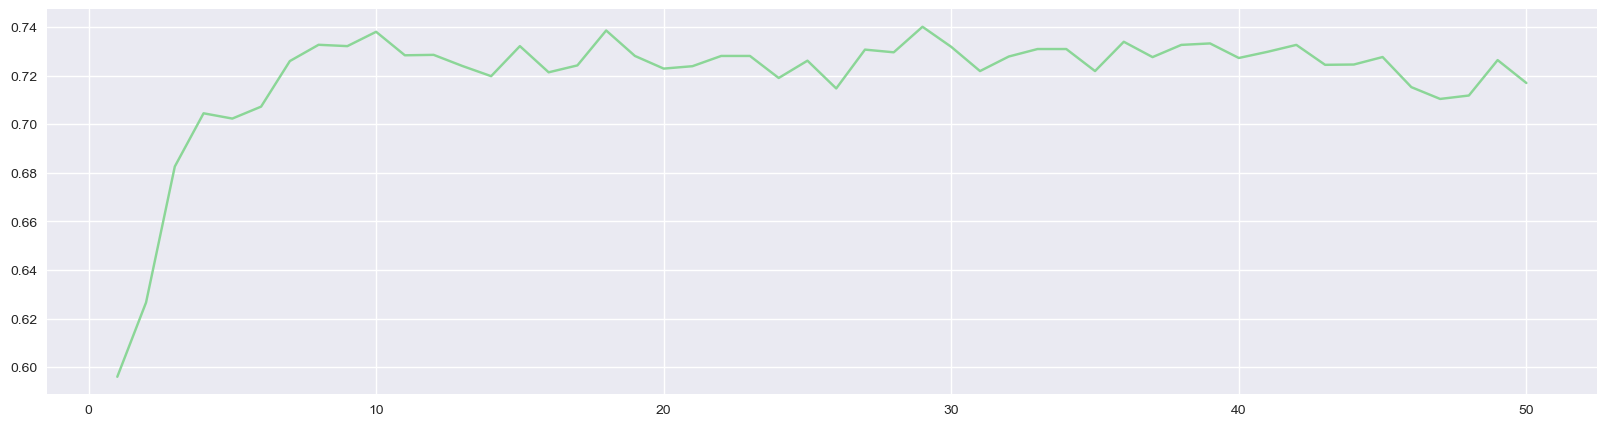

In [12]:
k_best_support, k_best_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_train
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='KBest'
                                            , metric = 'roc_auc'
                                            , max_features = 50
                                        )


100%|██████████| 30/30 [2:25:13<00:00, 290.44s/it]  

Optimum number of features: 28
Score (roc_auc) with 28 features: 73.586826
[2023_09_19-01_10_27] TE: 2 hours 25 minutes e 13 seconds


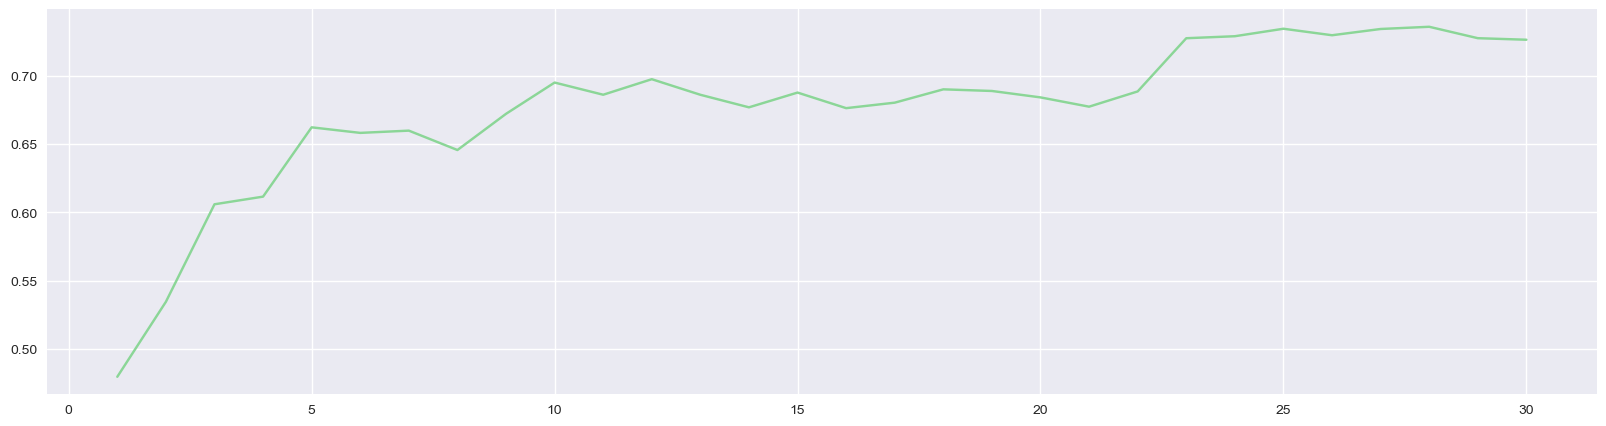

In [ ]:
rfe_support, rfe_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_train
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='RFE'
                                            , metric = 'roc_auc'
                                            , max_features = 30
                                        )


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]

Optimum number of features: 12
Score (roc_auc) with 12 features: 74.982036
[2023_09_18-22_10_58] TE: 33 seconds


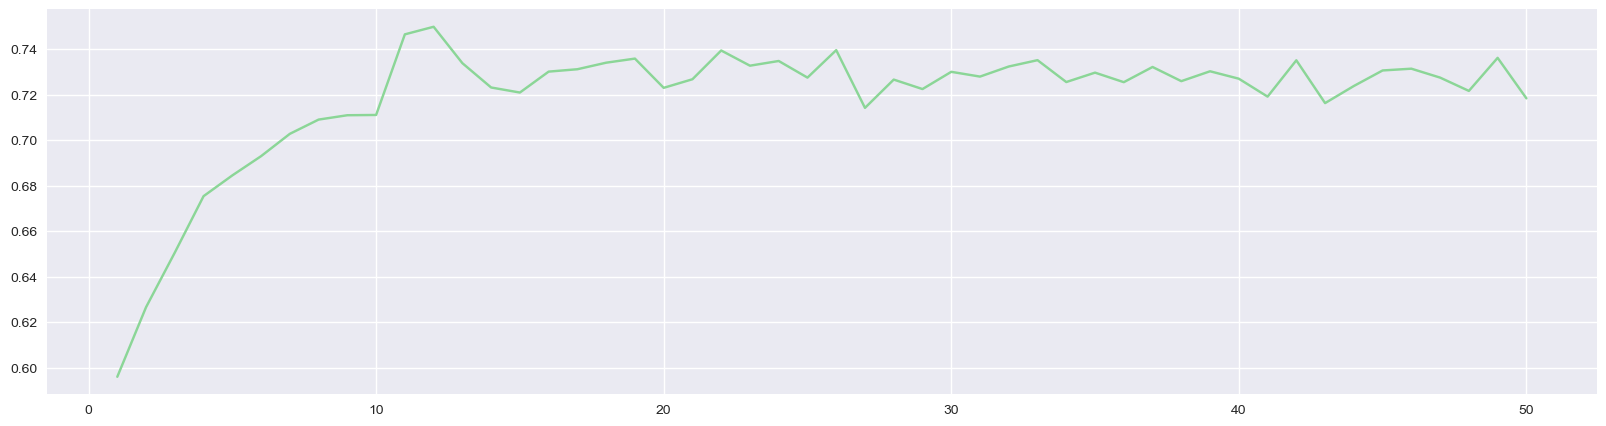

In [ ]:
FM_support, FM_features=loop_k_features(
                                        X=X_train_preprocessed
                                        , y=y_train
                                        , model=LGBMClassifier(random_state=SEED)
                                        , method='FromModel'
                                        , metric = 'roc_auc'
                                        , max_features = 50
                                    )

Best alpha using built-in LassoCV: 0.006190
Best score using built-in LassoCV: 0.218020
Lasso picked 58 variables and eliminated the other 778 variables


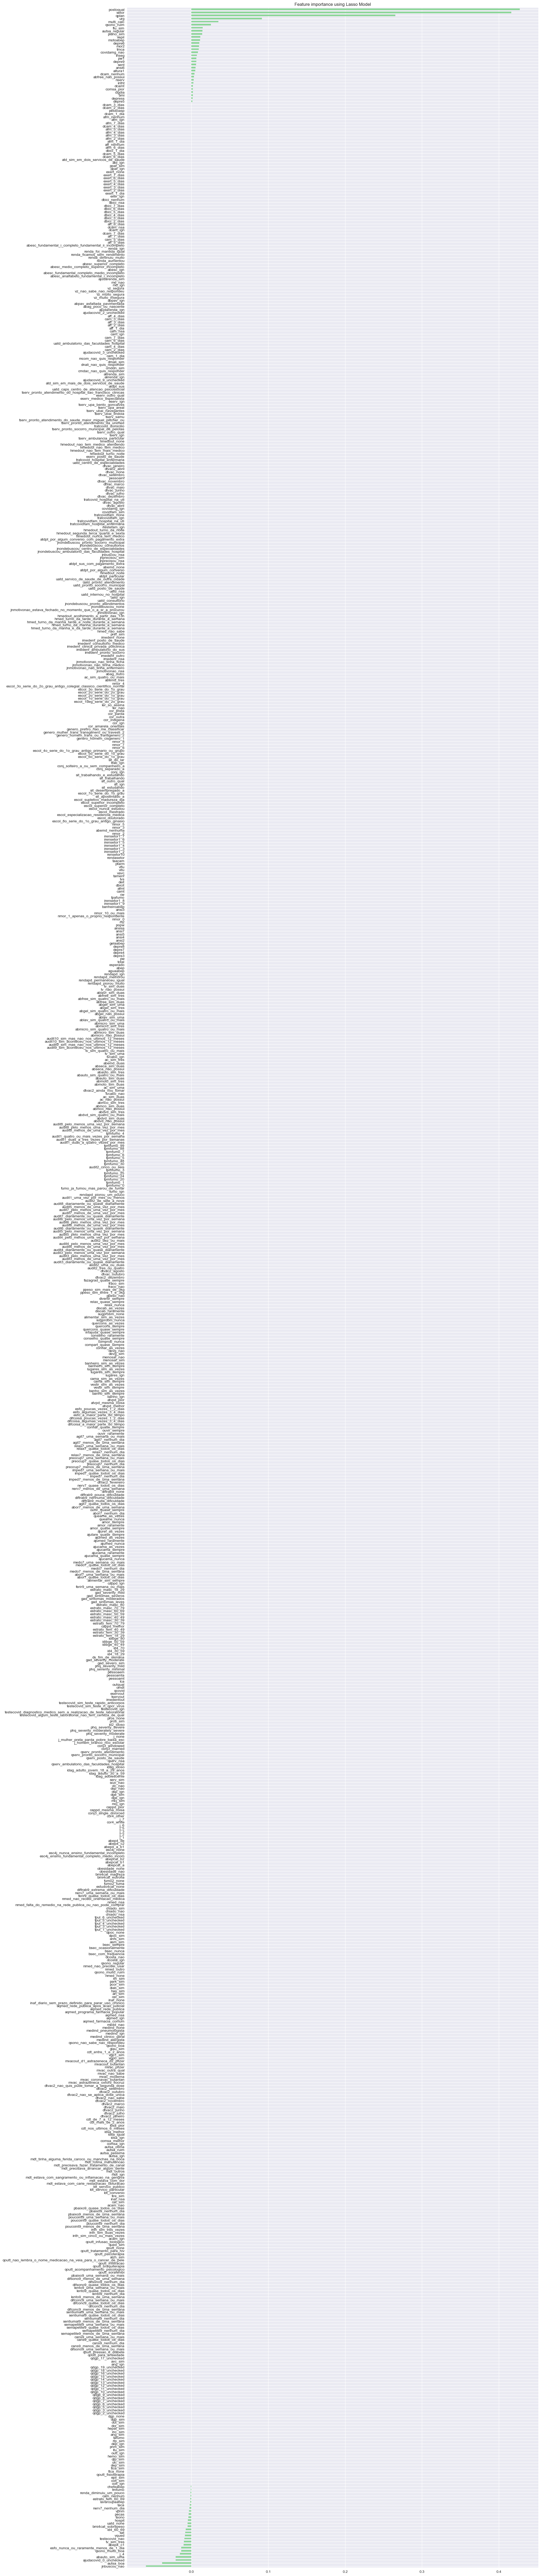

In [ ]:
Lasso_support, Lasso_features = Lasso_selection(X=X_train_preprocessed, y=y_train,eps=0.05, n_alphas=100,cv=10)

In [ ]:
borutashap_support, borutashap_features = BorutaShap_selection(
      X=X_train_preprocessed
    , y=y_train
    , model=LGBMClassifier(n_estimators = 100, random_state=SEED)
    , kwargs={"n_trials": 100, "random_state": 0, "normalize": False, "verbose": False}
)

Starting BorutaShap



  0%|          | 0/100 [00:00<?, ?it/s]

0 tentative features are now accepted: []
0 tentative features are now rejected: []
BorutaShap picked 6 variables and eliminated the other 830 variables


In [ ]:
# original_features = X_train.columns

# selected_features_original = list(set([
#             input_col
#             for input_col in original_features
#             if any(
#                 input_col == selected_col.split("___-")[0]
#                 for selected_col in borutashap_features
#             )
#         ]))

# X_train_selected=X_train[selected_features_original]
# X_test_selected=X_test[selected_features_original]

# if not osp.exists(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta'))):
#     os.mkdir(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta')))
    
# print('X_train.shape: ', X_train_selected.shape)
# print('X_test.shape: ', X_test_selected.shape)

# pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_train.parquet'))
# pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_test.parquet'))

In [ ]:
voting_dict={'Features': X_train_preprocessed.columns
             ,'KBest':k_best_support
             ,'RFE': rfe_support
             ,'FM':FM_support
             ,'Lasso':Lasso_support
             ,'BorutaShap':borutashap_support
             }

selected_features, feature_selection_df=voting(voting_dict,threshold=3)

feature_selection_df.to_parquet(osp.join('..', 'data', 'feature_selection', 'fs','feature_selection_df.parquet'))
feature_selection_df

,Features,KBest,RFE,FM,Lasso,BorutaShap,Total
1,setor,True,True,True,True,True,5
2,qplan,True,True,True,True,True,5
3,postoqual,True,True,True,True,True,5
4,nserv,False,True,True,True,True,4
5,bmi,False,True,True,True,True,4
6,urg,True,False,False,True,True,3
7,sent,False,True,True,True,False,3
8,qcovid,True,True,True,False,False,3
9,pessoaem,True,True,True,False,False,3
10,multi_calc,True,True,False,True,False,3


In [ ]:
feature_selection_df = pd.read_parquet(osp.join(DATA_DIR, 'fs','feature_selection_df.parquet'))

In [ ]:
selected_features = feature_selection_df['Features'].to_list()

In [ ]:
original_features = X_train.columns


def get_selected_features_original(original_features, selected_features):
    selected_features_original = list(set([
                input_col
                for input_col in original_features
                if any(
                    input_col == selected_col.split("___-")[0]
                    for selected_col in selected_features
                )
            ]))
    return selected_features_original

selected_features_original =get_selected_features_original(original_features, selected_features)

In [ ]:
X_train_selected=X_train[selected_features_original]
X_test_selected=X_test[selected_features_original]

print('X_train.shape: ', X_train_selected.shape)
print('X_test.shape: ', X_test_selected.shape)

X_train.shape:  (2444, 12)
X_test.shape:  (1048, 12)


In [ ]:
X_train_selected.sample(10)

,nserv,bmi,qcovid,multi_calc,altura1,setor,sent,postoqual,urg,qplan,depress,pessoaem
2812,0.00,NaN,None,0,NaN,431440705180028 - AREAL,420.00,None,0.00,None,0.00,Outro
3059,0.00,38.45,None,0,153.00,431440705160096 - CENTRO,120.00,None,0.00,Ype,0.00,Filha
988,3.00,36.07,Dec-20,1,148.00,431440705200004 - SÃO GONÇALO,150.00,Ubs fátima,1.00,Saude familiar,0.00,Esposo
84,0.00,24.09,None,1,163.00,431440705150064 - FRAGATA,999.00,None,0.00,Amor e saude,0.00,Esposo
2350,0.00,NaN,None,0,NaN,"431440705150080, FRAGATA",120.00,Ubs guabiroba,0.00,None,0.00,Amigo
1058,1.00,21.88,Aug-21,0,160.00,431440705160010 - CENTRO,720.00,None,1.00,None,5.00,Mãe
1434,0.00,24.62,None,1,178.00,431440705160023 - CENTRO,420.00,None,0.00,None,0.00,Esposa
2515,0.00,26.04,outubro de 2021,2,158.00,"431440705150044, FRAGATA",300.00,None,0.00,unimed,0.00,Esposo
1279,0.00,24.00,Feb-21,1,150.00,431440705160083 - CENTRO,600.00,None,0.00,None,0.00,Tia
483,0.00,32.98,None,0,175.00,431440705130101 - TRÊS VENDAS,300.00,Sanga funda,0.00,None,0.00,Esposa


In [ ]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'fs'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'fs')))

pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'fs','df_train.parquet'))
pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'fs','df_test.parquet'))

In [ ]:
selected_features = feature_selection_df[feature_selection_df['BorutaShap']]['Features'].to_list()

In [ ]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'boruta'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'boruta')))
    
selected_features = feature_selection_df[feature_selection_df['BorutaShap']]['Features'].to_list()
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'boruta','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'boruta','df_test.parquet'))

In [ ]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'FM'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'FM')))
    
selected_features = feature_selection_df[feature_selection_df['FM']]['Features'].to_list()
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'FM','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'FM','df_test.parquet'))

In [ ]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'FM_MUST'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'FM_MUST')))
    
selected_features = feature_selection_df[feature_selection_df['FM']]['Features'].to_list() + must_have_features
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'FM_MUST','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'FM_MUST','df_test.parquet'))

In [ ]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'fs_must'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'fs_must')))
    
selected_features = feature_selection_df['Features'].to_list() + must_have_features
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'fs_must','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'fs_must','df_test.parquet'))